In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\Users\danie\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


```python
import matplotlib.pyplot as plt

def plot_distribs(ubi_array, x=250):
    # Set the figure size
    plt.figure(figsize=(18, 6))  # Width: 12 inches, Height: 6 inches
    colors = plt.cm.viridis(np.linspace(0, 1, len(ubi_array)))
    # Plot the bar chart
    for i, df in enumerate(ubi_array):
        df = df.drop(df[df['Income Range'].str.split('-').str[-1].astype(int) > x*1000].index)
        plt.bar(range(len(df)), df["Number of People"], color = colors[i] )
        
    # Set x-tick positions to every fifth element
    plt.xticks(np.arange(0, len(df), 5))

    tick_labels = [df["Income Range"].iloc[i] if i % 25 == 0 else '' for i in range(0,len(df),5)]
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.gca().set_xticklabels(tick_labels)

    # Add labels and title
    plt.xlabel('Income Range, Thousands')
    plt.ylabel('Number of People')
    plt.title('Frequency Chart of Income Distribution')

    # Show plot
    plt.show()


In [2]:
#Choose number of periods to model
I = 5

## Generate the income distribution

In [3]:
import numpy as np
# Desired mean and mode (peak)
mean_X = 50000  # Desired mean
mode_X = 25000  # Desired mode (peak)
pop = 1*(10**3)

# Calculate parameters for the log-normal distribution
sigma_log = np.sqrt(np.log(1 + ((mode_X / mean_X)**2)))
mu_log = np.log(mean_X) - (0.5 * sigma_log**2)

# Generate random numbers following a log-normal distribution
random_numbers = np.random.lognormal(mu_log, sigma_log, pop)

# Define income range increments
income_increments = np.arange(0, max(random_numbers) + 1000, 1000)

# Create frequency table using NumPy's histogram function
frequencies, bins = np.histogram(random_numbers, bins=income_increments)

# Create a DataFrame from the frequency table
frequency_df = pd.DataFrame({'Income Range': [f'${int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins) - 1)],
                             'Number of People': frequencies})





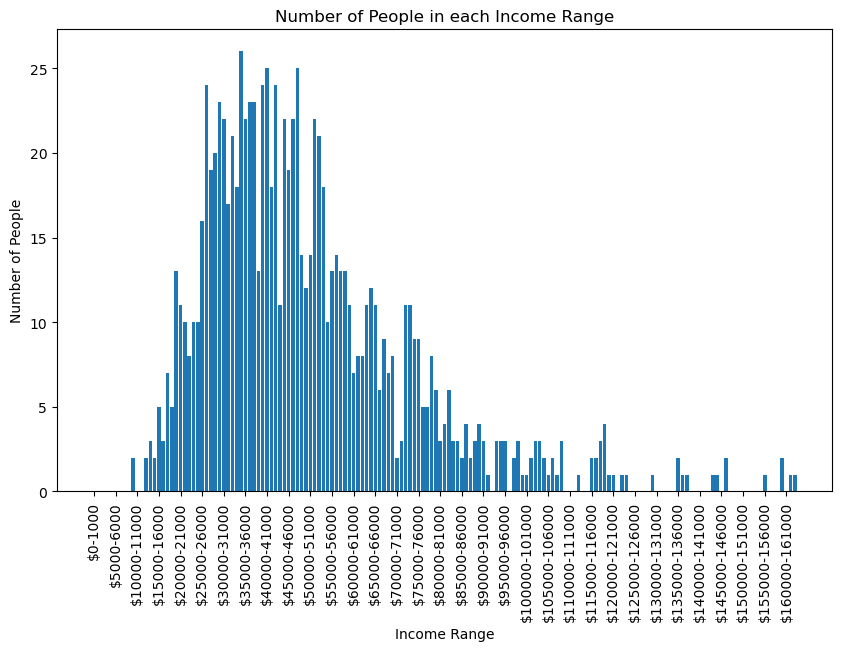

In [4]:
import matplotlib.pyplot as plt

# Assuming frequency_df is your DataFrame and it has columns 'Income Range' and 'Number of People'
plt.figure(figsize=(10,6))
plt.bar(frequency_df['Income Range'], frequency_df['Number of People'])
plt.xticks(frequency_df['Income Range'][::5], rotation = 90)

plt.xlabel('Income Range')
plt.ylabel('Number of People')
plt.title('Number of People in each Income Range')
plt.show()


In [5]:
len(frequency_df)

163

## Define a function that makes a concave output wrt x

In [6]:



def concave_function(x):
    return 1.5 * np.sqrt(x / 150000)

# Test the function with x = 0 and x = 150000


## Define a function that iteratively generates variables cols for each period

In [7]:
data = pd.DataFrame({'lab_income_1': random_numbers})


def gen_period_i(data = data, i = 1, tax = 0.2, r = 0.2, s=0.2, a =0.4):
    covered_columns = []
    for x in range(1, i+1, 1): 
        data['capital_1'] = concave_function(data['lab_income_1'])*data['lab_income_1']
        data['inv_income_' + str(x)] = r * data['capital_' + str(x)]
        data['income_' + str(x)] = data['lab_income_' + str(x)] + data['inv_income_' + str(x)]
        data['category_1'] = pd.cut(data['lab_income_1'], bins=bins, labels=frequency_df['Income Range'])
        data['tax_' + str(x)] = (data['income_' + str(x)] + data['inv_income_' + str(x)])* tax
        data['ubi_amount_' + str(x)] = (0.4 * sum(data['tax_' + str(x)]))/pop
        data['net_transfer_' + str(x)] = data['ubi_amount_' + str(x)] - data['tax_' + str(x)]
        data['disposable_income_' + str(x)] = (data['income_' + str(x)] + data['net_transfer_' + str(x)] + data['inv_income_' + str(x)])
        data['income_to_spend_' + str(x)] = (s-1)*data['disposable_income_' + str(x)]
        data['inv_' + str(x)] = (s)*data['disposable_income_' + str(x)]
        
        for col in data.columns:
            if col not in ['category_' + str(y) for y in range(1, i+2)] and col != 'lab_income_' + str(x+1) and col not in covered_columns:
                #print(col + ' BEING REVIEWED')
                cat_col = (col[:-2] + '_category_' + str(x))
                data[cat_col] = pd.cut(data[col], bins=bins, labels=frequency_df['Income Range'])
                covered_columns.append(col)
                covered_columns.append(cat_col)
                #print(covered_columns)
                #print(cat_col + ' added')
                        
        data['capital_' + str(x+1)] = data['capital_' + str(x)] + data['inv_' + str(x)] 
        # Capital investment domestically also improves labour productivity. Total return on investment is a times larger than r, which is the return to capital. a is the proportion that accumulates to capital 
        #accross the whole stream of production, and 1-a is the share that utlimately goes to labour. I.e. a is the capital share of income.
        data['lab_income_' + str(x+1)] = data['lab_income_' + str(x)] + ((1-a)/a)*(r)*data['capital_' + str(x+1)]
        
        #Categorisations
        #data['category_' + str(x+1)] = pd.cut(data['lab_income_' + str(x+1)], bins=bins, labels=frequency_df['Income Range'])
        
                
        
        
    return data
# Display the DataFrame
data = gen_period_i(i=I)
data.head()['inv_income_category_1']


0      $8000-9000
1    $10000-11000
2      $6000-7000
3      $4000-5000
4      $3000-4000
Name: inv_income_category_1, dtype: category
Categories (163, object): ['$0-1000' < '$1000-2000' < '$2000-3000' < '$3000-4000' ... '$159000-160000' < '$160000-161000' < '$161000-162000' < '$162000-163000']

In [8]:
print(", ".join(data.columns))

lab_income_1, capital_1, inv_income_1, income_1, category_1, tax_1, ubi_amount_1, net_transfer_1, disposable_income_1, income_to_spend_1, inv_1, lab_income_category_1, capital_category_1, inv_income_category_1, income_category_1, tax_category_1, ubi_amount_category_1, net_transfer_category_1, disposable_income_category_1, income_to_spend_category_1, inv_category_1, capital_2, lab_income_2, inv_income_2, income_2, tax_2, ubi_amount_2, net_transfer_2, disposable_income_2, income_to_spend_2, inv_2, capital_category_2, lab_income_category_2, inv_income_category_2, income_category_2, tax_category_2, ubi_amount_category_2, net_transfer_category_2, disposable_income_category_2, income_to_spend_category_2, inv_category_2, capital_3, lab_income_3, inv_income_3, income_3, tax_3, ubi_amount_3, net_transfer_3, disposable_income_3, income_to_spend_3, inv_3, capital_category_3, lab_income_category_3, inv_income_category_3, income_category_3, tax_category_3, ubi_amount_category_3, net_transfer_catego

In [9]:
data.head()

,lab_income_1,capital_1,inv_income_1,income_1,category_1,tax_1,ubi_amount_1,net_transfer_1,disposable_income_1,income_to_spend_1,...,inv_income_category_5,income_category_5,tax_category_5,ubi_amount_category_5,net_transfer_category_5,disposable_income_category_5,income_to_spend_category_5,inv_category_5,capital_6,lab_income_6
0,50780.170708,44318.684850,8863.736970,59643.907678,$50000-51000,13701.528930,5501.890593,-8199.638337,60308.006311,-48246.405049,...,$24000-25000,NaN,$40000-41000,$16000-17000,NaN,NaN,NaN,$35000-36000,155935.610585,200214.724396
1,57455.006363,53338.088195,10667.617639,68122.624002,$57000-58000,15758.048328,5501.890593,-10256.157736,68534.083905,-54827.267124,...,$28000-29000,NaN,$46000-47000,$16000-17000,NaN,NaN,NaN,$40000-41000,181077.354115,232278.608187
2,43052.174154,34596.985706,6919.397141,49971.571295,$43000-44000,11378.193687,5501.890593,-5876.303095,51014.665341,-40811.732273,...,$19000-20000,$145000-146000,$33000-34000,$16000-17000,NaN,$148000-149000,NaN,$29000-30000,128256.650534,164654.112078
3,30217.284774,20343.645798,4068.729160,34286.013934,$30000-31000,7670.948619,5501.890593,-2169.058026,36185.685067,-28948.548054,...,$13000-14000,$96000-97000,$21000-22000,$16000-17000,NaN,$104000-105000,NaN,$20000-21000,86040.806262,109696.561242
4,28125.910298,18268.610252,3653.722050,31779.632348,$28000-29000,7086.670880,5501.890593,-1584.780287,33848.574111,-27078.859289,...,$12000-13000,$89000-90000,$20000-21000,$16000-17000,NaN,$97000-98000,NaN,$19000-20000,79652.810661,101277.923570


In [10]:
pd.set_option("display.max_rows", 10) 

## Define a function that makes pivot tables for sum of a variable grouped by income_category_1

In [11]:
def make_groups(data, x =1, coltypes = ['lab_income_', 'inv_income_']):
    columns = [(col + str(x)) for col in coltypes]
    grouped_df = data.pivot_table(values = columns, index = 'income_category_' + str(x), aggfunc = 'sum', observed=False)
    return(grouped_df)
    
    
make_groups(data).iloc[100:120]

,inv_income_1,lab_income_1
income_category_1,,
$100000-101000,91254.358161,410936.628344
$101000-102000,36875.797662,165495.781380
$102000-103000,56232.830026,250985.785709
$103000-104000,57033.024932,253361.189287
$104000-105000,0.000000,0.000000
...,...,...
$115000-116000,44146.026453,186589.511681
$116000-117000,22248.265903,93787.946598
$117000-118000,90380.839647,379041.083306


## Define a function that makes an array of dataframes, 
1 for each period, each with one column which is each income category, and the others are the sums of other variables that are in each category/grouped by each category

In [12]:
def gen_ubi_array(data=data, i=1, coltypes = ['lab_income_', 'inv_income_']):
    ubi_array = []
    for x in range(1, i + 1):  # Corrected the range to include i
        grouped_df = make_groups(data, x=x, coltypes = coltypes).reset_index()
        ubi_array.append(grouped_df)
    return ubi_array
        
        
gen_ubi_array(i = I, coltypes = ['lab_income_', 'inv_income_', 'net_transfer_'])[1]

,income_category_2,inv_income_2,lab_income_2,net_transfer_2
0,$0-1000,0.000000,0.000000,0.000000
1,$1000-2000,0.000000,0.000000,0.000000
2,$2000-3000,0.000000,0.000000,0.000000
3,$3000-4000,0.000000,0.000000,0.000000
4,$4000-5000,0.000000,0.000000,0.000000
...,...,...,...,...
158,$158000-159000,0.000000,0.000000,0.000000
159,$159000-160000,26654.562194,133187.167270,-29992.909221
160,$160000-161000,26727.825573,133475.926062,-30079.966331
161,$161000-162000,26893.444835,134128.113851,-30276.651594


In [13]:
UBI = gen_ubi_array(i = I)

## Define and use a function that plots the distribution of the categorised variables for one of the periods in the ubi dataframe

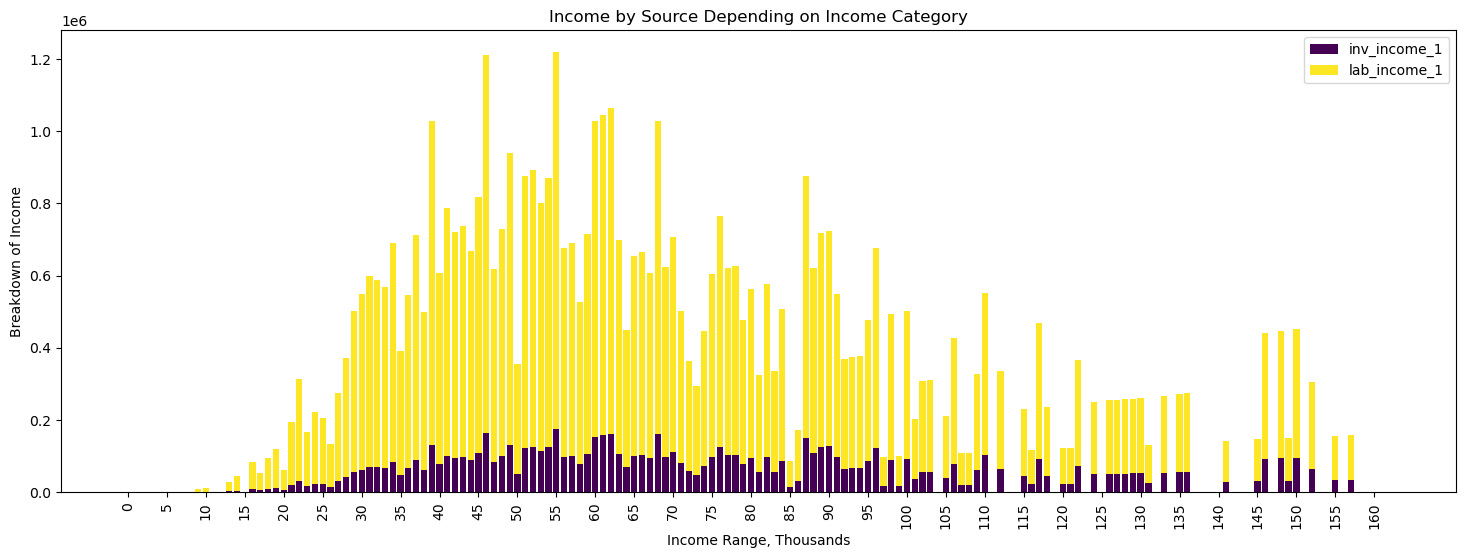

In [14]:
def plot_ubi(ubi, x=250, i = 0, coltype = 'income_category'):
        # Set the figure size
        plt.figure(figsize=(18, 6))  # Width: 12 inches, Height: 6 inches
        
        df = ubi
        df = df.drop(df[df[coltype + '_' + str(i+1)].str.split('-').str[-1].astype(int) > x*1000].index)
        bottom = None
        num_bars = len(ubi.columns[1:])
        colors = plt.cm.viridis(np.linspace(0, 1, num_bars))  # Generate a range of colors from yellow to red
        nth_bar = 0
        for n, col in enumerate(df.columns[1:]):
                if n == 0:
                    plt.bar(range(len(df)), df[col], color=colors[nth_bar], label=str(col))  # Use color from the gradient
                    bottom = df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1
                else:
                    plt.bar(range(len(df)), df[col], bottom=bottom, color=colors[nth_bar], label=str(col))  # Use color from the gradient
                    bottom += df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1

        # Set x-tick positions to every fifth element
        plt.xticks(np.arange(0, len(df), 5))


        #tick_labels = [df["Income Range"].iloc[i] if i % 25 == 0 else '' for i in range(0,len(df),5)]
        plt.xticks(rotation=90)  # Rotate labels for better readability
        #plt.gca().set_xticklabels(tick_labels)

        # Add labels and title
        plt.xlabel('Income Range, Thousands')
        plt.ylabel('Breakdown of Income')
        plt.title('Income by Source Depending on Income Category')
        plt.legend()

        # Show plot
        plt.show()
    
plot_ubi(ubi = UBI[0])

10


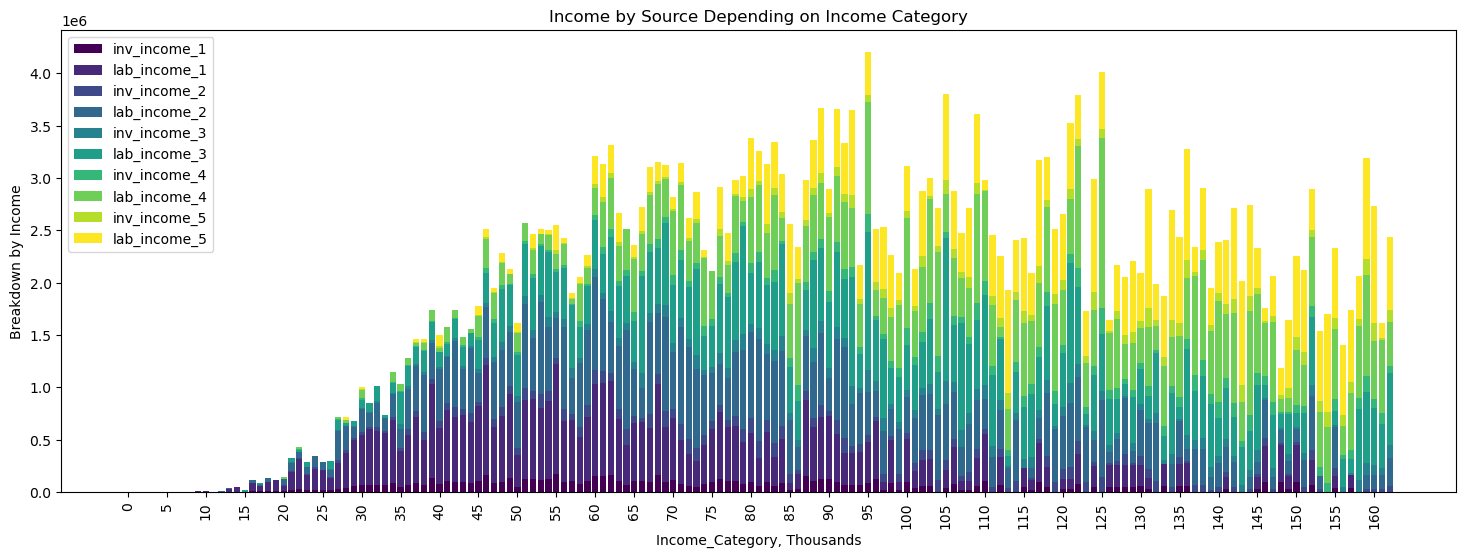

In [15]:


def plot_ubis(ubi_array, separate=True, x=250, coltype = 'income_category'):
    if separate:
        for i, df in enumerate(ubi_array):
            plot_ubi(df, i=i)
    else:
        plt.figure(figsize=(18, 6))
        bottom = None
        num_bars = len(ubi_array) * len(ubi_array[0].columns[1:])
        print(num_bars)
        colors = plt.cm.viridis(np.linspace(0, 1, num_bars))  # Generate a range of colors from yellow to red
        nth_bar = 0
        for i, df in enumerate(ubi_array):
            df = df.drop(df[df[coltype + '_' + str(i + 1)].str.split('-').str[-1].astype(int) > x * 1000].index) # drop all incomes above 250k
            for n, col in enumerate(df.columns[1:]):
                if n == 0:
                    if i == 0:
                        plt.bar(range(len(df)), df[col], color=colors[nth_bar], label=str(col))  # Use color from the gradient
                        bottom = df[col]  # Update the bottom values for subsequent sets of bars
                    else:
                        plt.bar(range(len(df)), df[col], bottom=bottom, color=colors[nth_bar], label=str(col))  # Use color from the gradient
                        bottom += df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1
                else:
                    plt.bar(range(len(df)), df[col], bottom=bottom, color=colors[nth_bar], label=str(col))  # Use color from the gradient
                    bottom += df[col]  # Update the bottom values for subsequent sets of bars
                    nth_bar += 1
        
        plt.xticks(np.arange(0, len(df), 5))
        plt.xticks(rotation=90)
        plt.xlabel(f'{str.title(coltype)}, Thousands')
        plt.ylabel('Breakdown by Income')
        plt.title('Income by Source Depending on Income Category')
        plt.legend()
        plt.show()

# Assuming x is defined elsewhere in your code
plot_ubis(UBI, separate=False)


## Generate summary statistics in a new table

In [28]:
data.agg([max, min])

C:\Users\danie\AppData\Local\Temp\ipykernel_31692\3448160133.py:1: FutureWarning: The provided callable <built-in function max> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data.agg([max, min])
C:\Users\danie\AppData\Local\Temp\ipykernel_31692\3448160133.py:1: FutureWarning: The provided callable <built-in function min> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  data.agg([max, min])


,lab_income_1,capital_1,inv_income_1,income_1,category_1,tax_1,ubi_amount_1,net_transfer_1,disposable_income_1,income_to_spend_1,...,inv_income_category_5,income_category_5,tax_category_5,ubi_amount_category_5,net_transfer_category_5,disposable_income_category_5,income_to_spend_category_5,inv_category_5,capital_6,lab_income_6
max,162644.721767,254042.039313,50808.407863,213453.129629,$162000-163000,52852.307498,5501.890593,3427.001631,216911.120586,-11041.157150,...,$109000-110000,$162000-163000,$153000-154000,$16000-17000,$9000-10000,$162000-163000,NaN,$143000-144000,693453.130117,864521.013007
min,9042.368953,3330.189634,666.037927,9708.406880,$9000-10000,2074.888961,5501.890593,-47350.416906,13801.446438,-173528.896469,...,$4000-5000,$28000-29000,$6000-7000,$16000-17000,$0-1000,$42000-43000,NaN,$8000-9000,29289.104650,33120.359609


In [36]:
gov_rev = np.zeros(I)

def summary_stats(data = data, cols=['tax', 'income', 'inv_income', 'lab_income'], periods=I, aggfuncs = 'sum'):
    # Create an empty DataFrame to store the summary stats
    col_df = pd.DataFrame(index=range(periods))
    for col in cols:
        for i in range(periods):
            # Calculate the sum of the column for each period and store it in the DataFrame
            for aggfunc in aggfuncs:
                col_df.at[i, col + '_' + aggfunc] = data[col + '_' + str(i+1)].agg(aggfunc)

    return col_df

# Assuming 'data' and 'I' are defined elsewhere in your code
summary_data = summary_stats(cols = ['income'], aggfuncs = ['mean', 'min', 'max'])
print(summary_data)


     income_mean    income_min     income_max
0   59385.085770   9708.406880  213453.129629
1   79519.985379  12087.608414  311356.853482
2  105271.037148  15709.843337  430982.103915
3  138393.273723  20988.081486  579620.619074
4  181154.480605  28487.824815  766470.058946


## Define a function that plots summary statistics accross time

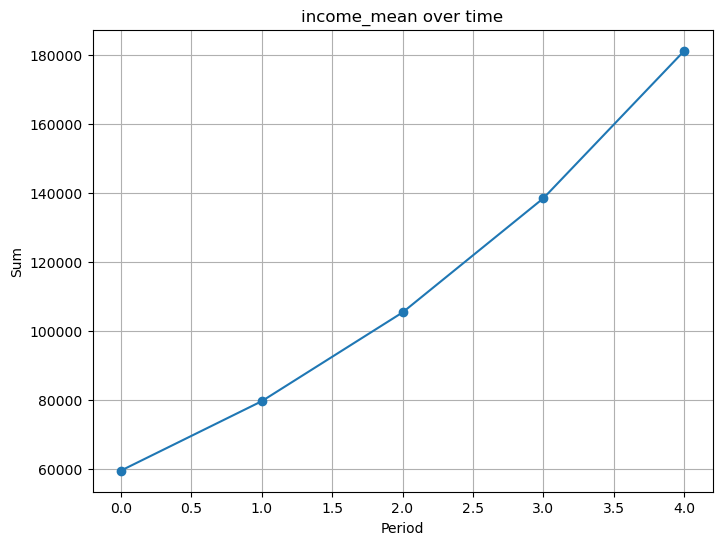

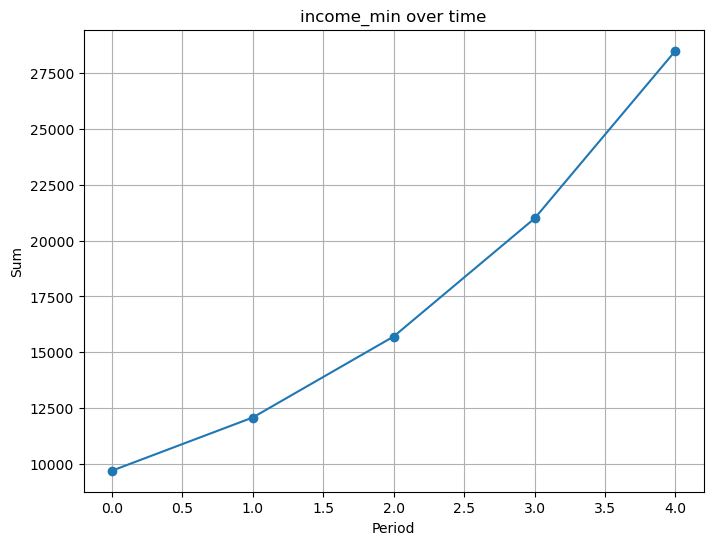

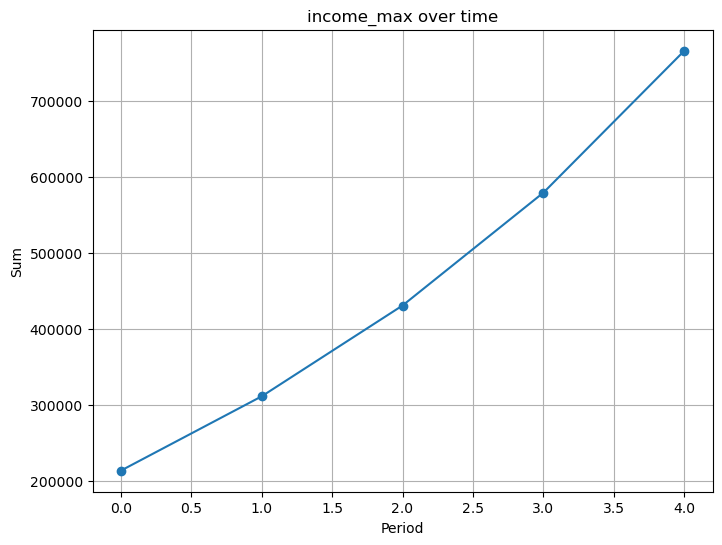

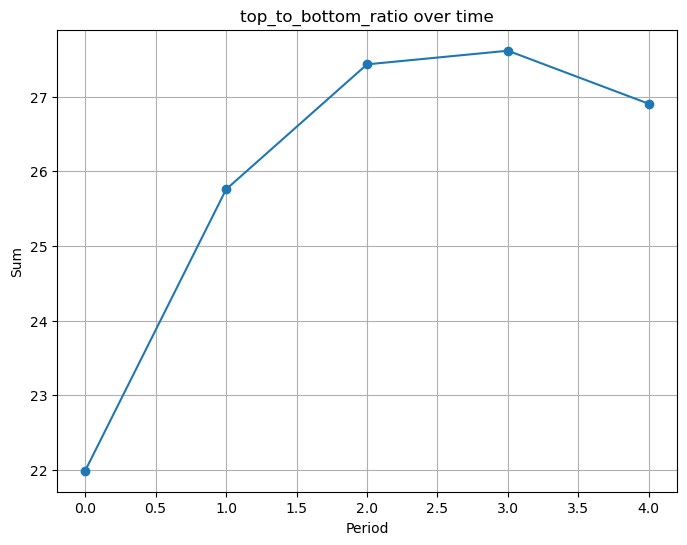

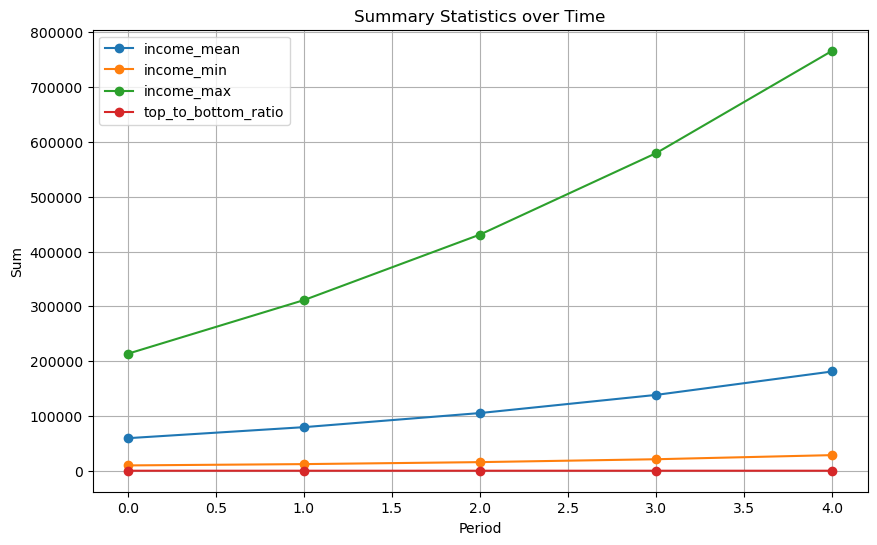

In [38]:


def plot_summary_stats(summary_data = summary_data):
    # Plot each column separately
    for col in summary_data.columns:
        plt.figure(figsize=(8, 6))
        plt.plot(summary_data.index, summary_data[col], marker='o', linestyle='-')
        plt.title(col + ' over time')
        plt.xlabel('Period')
        plt.ylabel('Sum')
        plt.grid(True)
        plt.show()

    # Plot all columns together on one subplot
    plt.figure(figsize=(10, 6))
    for col in summary_data.columns:
        plt.plot(summary_data.index, summary_data[col], marker='o', linestyle='-', label=col)
    plt.title('Summary Statistics over Time')
    plt.xlabel('Period')
    plt.ylabel('Sum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'summary_data' DataFrame is obtained from the previous step
summary_data['top_to_bottom_ratio'] = summary_data.income_max/summary_data.income_min
plot_summary_stats(summary_data)


## Define a function that makes a frequency table of a given column type

In [18]:
def make_freq_table(coltype = 'income_category', i = 1):
    ubi = data[str(coltype) + '_' + str(i)].value_counts().reset_index()
    ubi.columns = [coltype, 'Number of People']

    # Sort the frequency table by income range
    ubi = ubi.sort_values(by=coltype)
    # Display the frequency table
    return(ubi)


## Generate multiple frequency tables

### Test for each i

In [19]:
ubi1 = make_freq_table(i=1)
ubi2 = make_freq_table(i=2)
ubi3 = make_freq_table(i=3)
ubi4 = make_freq_table(i=4)
ubi5 = make_freq_table(i=5)

### Define a function that does the above cell in one go

In [20]:
def ubi_multiple(data = data, i=1, coltype = 'income_category'):
    ubi_multiple = []
    print(ubi_multiple)
    for x in range(0,i):
        ubi_multiple.append(make_freq_table(i = x+1, coltype = coltype))
        
    return ubi_multiple
#ubi_multiple(i=5)

## Plot the distributions of different variables

[]


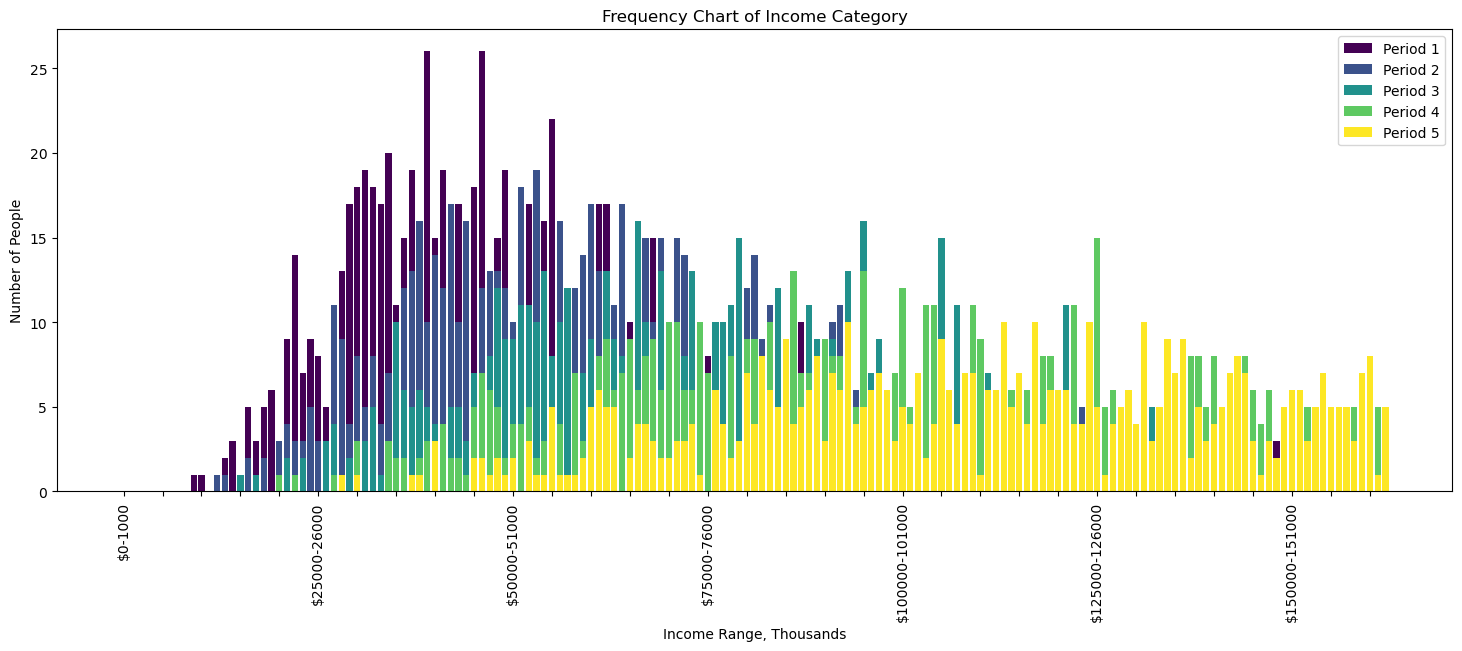

In [21]:
def plot_distribs(ubi_array, x=250, coltype = 'income_category'):
    # Set the figure size
    plt.figure(figsize=(18, 6))  # Width: 12 inches, Height: 6 inches
    colors = plt.cm.viridis(np.linspace(0, 1, len(ubi_array)))
    # Plot the bar chart
    for i, df in enumerate(ubi_array):
        df = df.drop(df[df[coltype].str.split('-').str[-1].astype(int) > x*1000].index)
        plt.bar(range(len(df)), df["Number of People"], color = colors[i], label = 'Period ' + str(i+1))
        
    # Set x-tick positions to every fifth element
    plt.xticks(np.arange(0, len(df), 5))

    tick_labels = [df[coltype].iloc[i] if i % 25 == 0 else '' for i in range(0,len(df),5)]
    plt.xticks(rotation=90)  # Rotate labels for better readability
    plt.gca().set_xticklabels(tick_labels)

    # Add labels and title
    plt.xlabel('Income Range, Thousands')
    plt.ylabel('Number of People')
    plt.title('Frequency Chart of ' + coltype.replace('_',' ').title())
    plt.legend()

    # Show plot
    plt.show()

plot_distribs(ubi_multiple(i=I))

[]


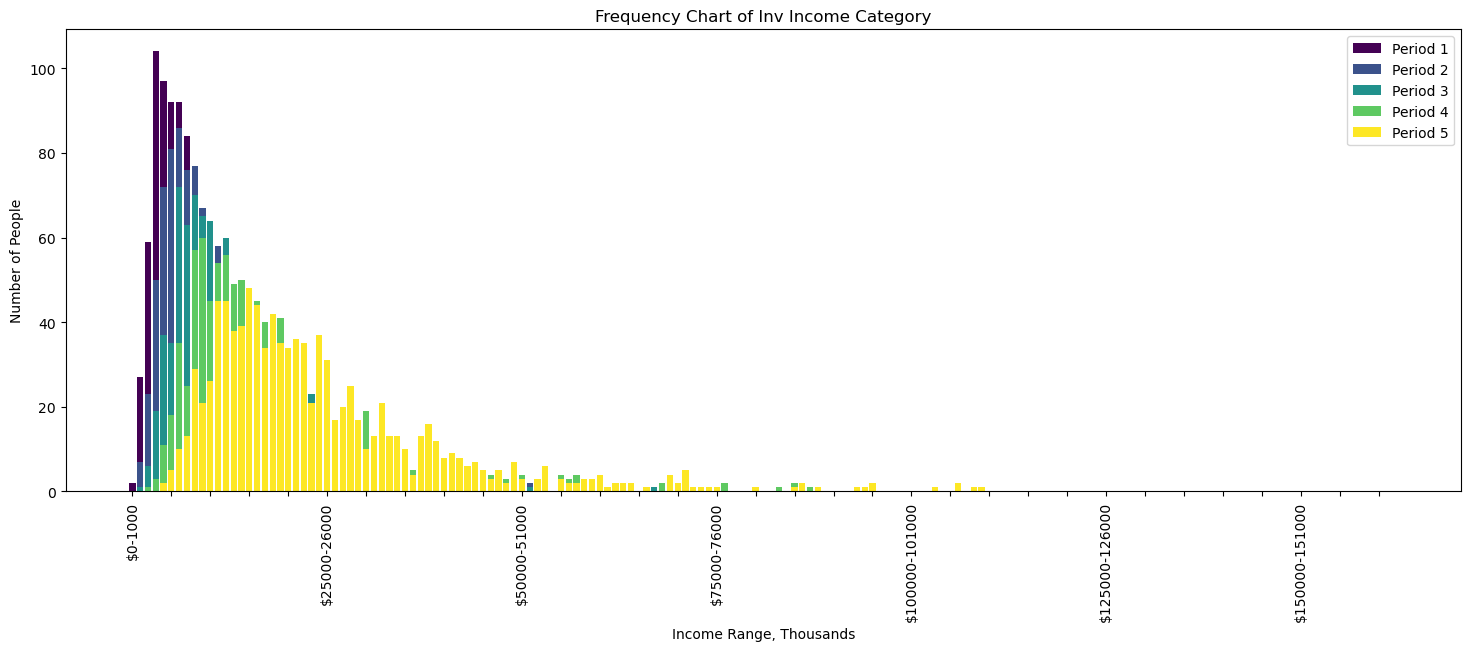

[]


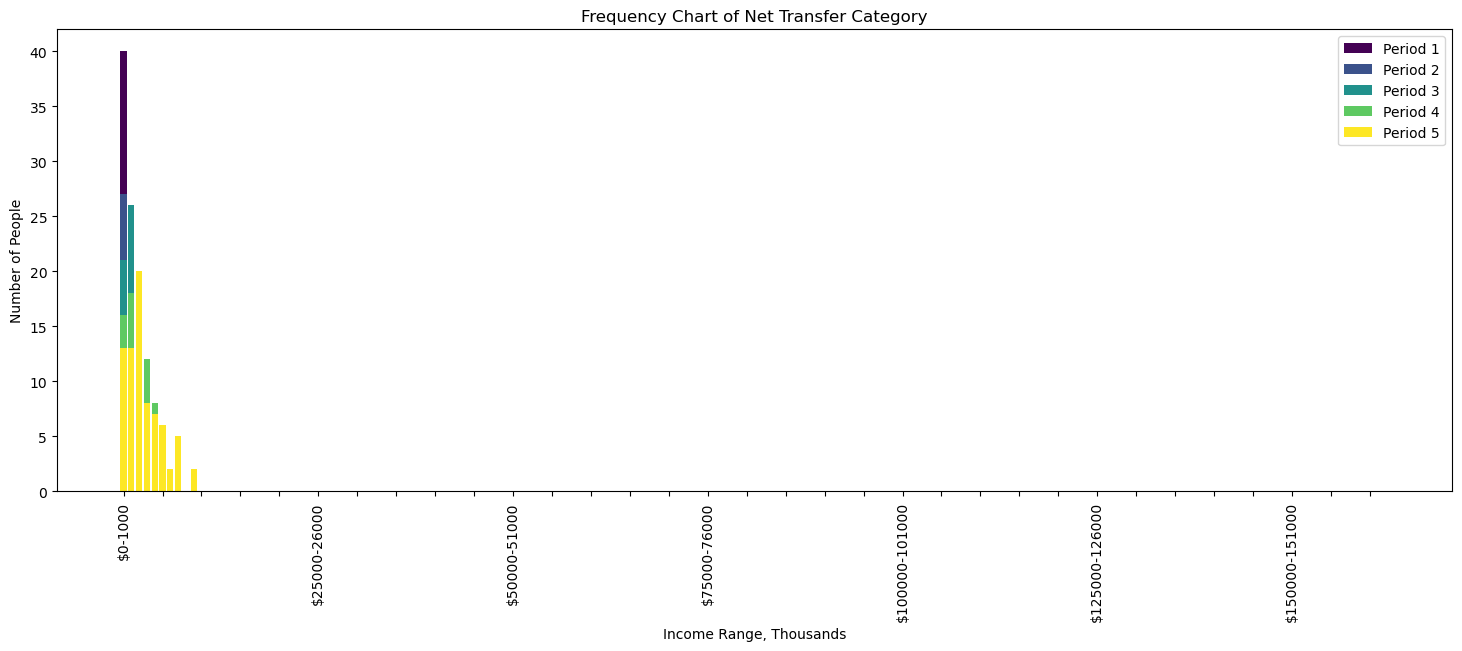

[]


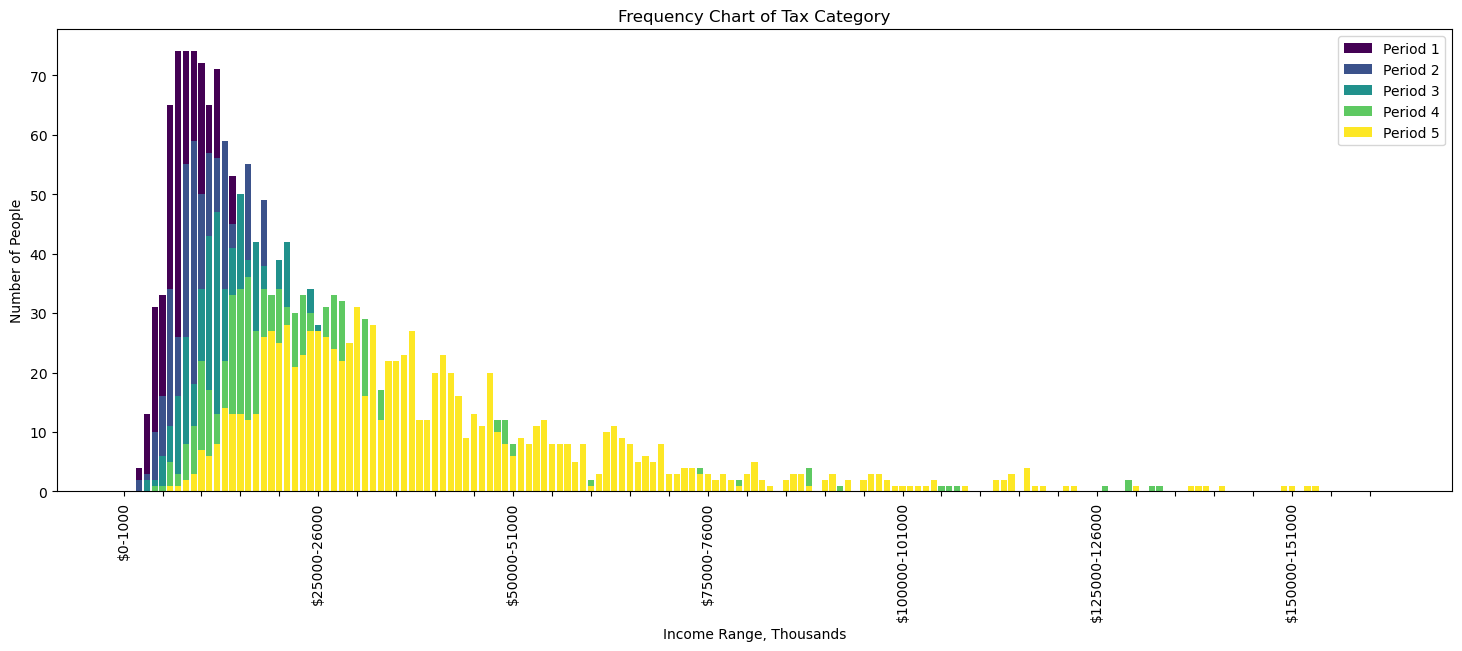

In [22]:
cols_list = ['inv_income_category','net_transfer_category', 'tax_category']
for coltype in cols_list:
    plot_distribs(ubi_multiple(i=I, coltype = coltype),coltype = coltype)

[]


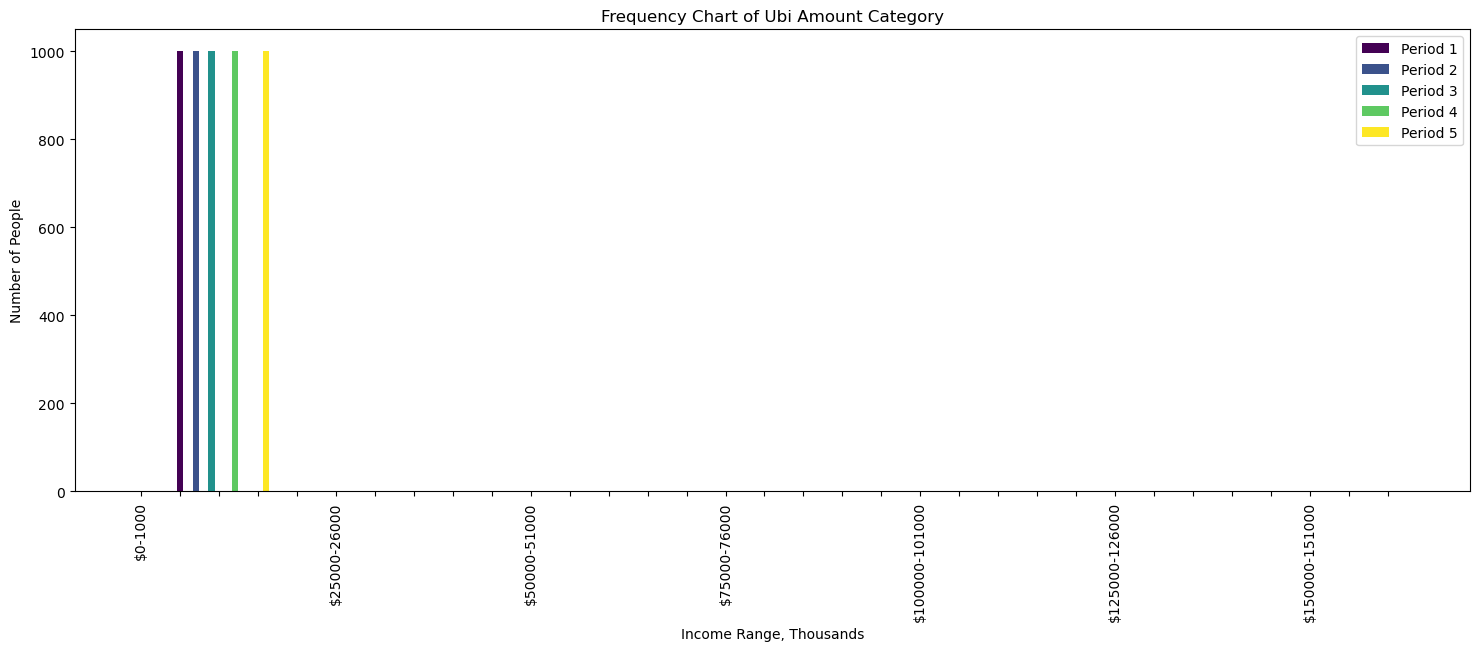

In [23]:
cols_list = ['ubi_amount_category']
for coltype in cols_list:
    plot_distribs(ubi_multiple(i=I, coltype = coltype),coltype = coltype)